In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the encoder model
latent_dim = 128

encoder_inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, padding='same', activation='relu')(encoder_inputs)
x = Conv2D(64, 3, strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2D(64, 3, strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2D(128, 3, strides=(2, 2), padding='same', activation='relu')(x)
x = Flatten()(x)
latent_space = Dense(latent_dim, name='latent_space')(x)

encoder = Model(encoder_inputs, latent_space, name='encoder')

# Define the decoder model
latent_inputs = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 128)(latent_inputs)
x = Reshape((7, 7, 128))(x)
x = Conv2DTranspose(64, 3, strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(64, 3, strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
decoder_outputs = Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# Define the VAE model
vae_outputs = decoder(encoder(encoder_inputs))
vae = Model(encoder_inputs, vae_outputs, name='vae')

# Define the VAE loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = K.mean(K.square(inputs - outputs), axis=[1, 2, 3])
    kl_loss = -0.5 * K.mean(1 + K.log(K.square(K.std(inputs))) - K.square(K.mean(inputs)) - K.square(K.std(inputs)))
    return reconstruction_loss + kl_loss

# Compile the VAE model
vae.compile(optimizer='adam', loss=vae_loss)

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the images
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Split the dataset
train_size = int(0.8 * len(x_train))
x_train, x_val = x_train[:train_size], x_train[train_size:]

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)

11490434/11490434 [==============================] - 2s 0us/step
x_train shape: (48000, 28, 28, 1)
x_val shape: (12000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [ ]:
# Train the VAE model
epochs = 40
batch_size = 128

vae.fit(x_train, x_train, 
        validation_data=(x_val, x_val), 
        epochs=epochs, 
        batch_size=batch_size)



Epoch 1/40
375/375 [==============================] - 7s 19ms/step - loss: 0.7335 - val_loss: 0.7399
Epoch 2/40
375/375 [==============================] - 7s 19ms/step - loss: 0.7335 - val_loss: 0.7399
Epoch 3/40
375/375 [==============================] - 7s 19ms/step - loss: 0.7335 - val_loss: 0.7399
Epoch 4/40
375/375 [==============================] - 7s 19ms/step - loss: 0.7335 - val_loss: 0.7399
Epoch 5/40
375/375 [==============================] - 7s 19ms/step - loss: 0.7334 - val_loss: 0.7398
Epoch 6/40
375/375 [==============================] - 7s 18ms/step - loss: 0.7334 - val_loss: 0.7398
Epoch 7/40
375/375 [==============================] - 7s 19ms/step - loss: 0.7334 - val_loss: 0.7398
Epoch 8/40
375/375 [==============================] - 7s 19ms/step - loss: 0.7334 - val_loss: 0.7398
Epoch 9/40
375/375 [==============================] - 7s 19ms/step - loss: 0.7334 - val_loss: 0.7398
Epoch 10/40
375/375 [==============================] - 8s 20ms/step - loss: 0.7333 - val_lo

1/1 [==============================] - 0s 20ms/step


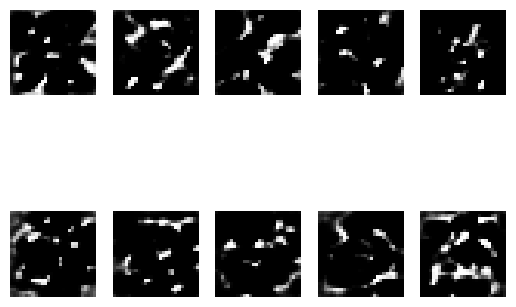

In [11]:
# Generate new images
latent_samples = np.random.normal(size=(10, latent_dim))
generated_images = decoder.predict(latent_samples)

# Rescale generated images to 0-255 range
generated_images = generated_images * 255.0
generated_images = generated_images.astype(np.uint8)

# Display the generated images
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
vae.save('vae_model.h5')

# using with fastapi


In [ ]:
from fastapi import FastAPI
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import base64
from PIL import Image
from io import BytesIO
app = FastAPI()
vae = load_model('vae_model.h5')  # Path to your trained VAE model file
latent_dim = 128

@app.post('/generate_image')
def generate_image():
    # Generate new image
    latent_samples = np.random.normal(size=(1, latent_dim))
    generated_image = vae.decoder.predict(latent_samples)

    # Rescale and convert image to base64
    generated_image = generated_image.reshape(28, 28) * 255.0
    generated_image = generated_image.astype(np.uint8)
    pil_image = Image.fromarray(generated_image)
    buffered = BytesIO()
    pil_image.save(buffered, format="PNG")
    encoded_image = base64.b64encode(buffered.getvalue()).decode('utf-8')

    return {'image': encoded_image}